# The Lorenz-96 and its GCM Analog

The physical equations of motion of the system describing the atmosphere dynamics are known. Also in the real atmosphere there is variability over all scales, from the smallest molecular scales to the largest planetary scales.
Thus, it is not feasible to explicitly solve the known physical equations of motion within Global Climate Models (GCMs), as computational resources limit the range of scales that can be resolved. To make the behavior of the GCM better match the real world, we need to effectively parameterize the effects that the unresolved scales have on the resolved (large) scales.

The two time-scale L96 model, described in the the [previous notebook](https://m2lines.github.io/L96_demo/notebooks/L96-two-scale-description.html#), can be considered as a simplified analog for real world atmosphere, where variability resides at only two discrete scales (a simplification of the continuum in the real world). In this analogy, a GCM would be a model that can only solve the equations for the slow time scale, where the effects of the fast time-scale variables would be missing. We introduce the single time-scale version of the L96 model below. To make the single time scale model match the two time scale model, the effects of the fast time scales need to parameterized into the single time scale model.

## The two time-scale model: analog for the real atmosphere

We will first describe a simulation with the two time-scale model from the {doc}`L96-two-scale-description`, which is taken as the control simulation that we hope to replicate with the single time-scale model. 

The forcing and resolution parameters, $F$, $J$ and $K$, for the two time-scale model are fixed based on {cite}`Wilks2005`, as $F=18$ or $20$, $K=8$, and $J=32$. Here, the value chosen for the parameter $F$ is set large enough to ensure chaotic behavior. We also use the reference values for the $h$, $b$ and $c$ parameters to be, $h=1$, $b=10$, and $c=10$.
With this particular choice of parameter values, one model time unit (MTU) is approximately equivalent to five atmospheric days. This estimate is obtained by comparing error-doubling times in the Lorenz-96 model and the real atmosphere {cite}`Lorenz1995`.

In the following code, we solve the L96 system using an accurate time-stepping scheme (RK4 with sufficiently small $\Delta t$), and plot the time evolution for the $X_k$ and $Y_{j,k}$ variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from L96_model import L96
from L96_model import L96_eq1_xdot

In [2]:
np.random.seed(23)
W = L96(8, 32)

%time X,Y,t = W.run(0.01, 20.)

CPU times: user 3.63 s, sys: 57.2 ms, total: 3.69 s
Wall time: 3.69 s


Here is the what the solution looks like:

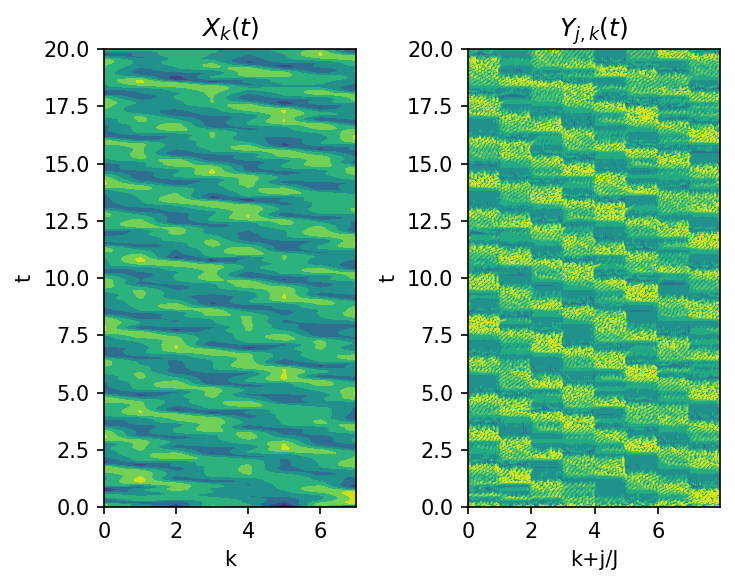

In [3]:
plt.figure(figsize=(5, 4), dpi=150)

plt.subplot(121)
plt.contourf(W.k, t, X)
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$")

plt.subplot(122)
plt.contourf(W.j / W.J, t, Y, levels=np.linspace(-1, 1, 10))
plt.xlabel("k+j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$")

plt.tight_layout()

## The single time-scale model: Analog for a general circulation model (GCM)

The two time-scale model discussed above solves a set of equations for the slow and fast variables, where the equations for the slow variables are:

\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \underbrace{ 
\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
}_{=U_k} \ ,
\end{align}

where the effects of the fast scales on the slow scales are represented by the last term on the RHS, denoted as $U_k$, $k=1,\ldots,k$. 

We consider the single time-scale model to be one where explicit equations for the fast scales are not solved, and so we do not know what $Y_{j,k}$ or subsequently $U_k$ are. In this single time-scale model the effects of the fast scales are either missing, assume $U_k=0$, or need to be parameterized in terms of the known slow time-scale variables, $P (X_k) \approx U_k$.

### The parametization $P(X_k)$

The one time-scale equation of the Lorenz-96 model with a parameterization for the effects of the fast time-scale or "unresolved scales", also called sub-grid forcing, can be written as:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - P\left( X_k \right) \ .
\end{align}

In this notebook, we consider the particular choice of modeling the unknown parameterization with a plynomial approximation. 
Example of such a parameterization include the form proposed by
{cite}`Wilks2005`: 
\begin{equation*}
P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + b_4 X_k^4 + e_k
\end{equation*}
where $e_k$ is a stochastic component. 

Alternatively, we also consider a lower-order polynomial as suggested by
{cite}`Arnold2013`: 
\begin{equation*}
P(X_k)=b_0 + b_1 X_k + e_k
\end{equation*}

In summary: with the "real world atmosphere" system in hand, we can "observe" the effect of the sub-grid forcing on the large scale ($U_k$) and test the skill of the polynomial function, $P(X_k)$, models/parameterizations.


In the following code segment, we solve the one time-scale Lorenz-96 system using an inaccurate time-stepping (Euler-forward with only-just stable $\Delta t$) and an unknown parameterization of the "unresolved processes", $P(X_k)$. 

In [4]:
%time X, Y, t = W.run(0.05, 200.) # We run the 2 time-scale model again for longer time, to generate more data.

CPU times: user 13.8 s, sys: 44.6 ms, total: 13.9 s
Wall time: 13.9 s


In [5]:
X_copy = X
# Generate U_k samples from 2 time-scale model
U_sample = (W.h * W.c / W.b) * Y.reshape((Y.shape[0], W.K, W.J)).sum(axis=-1)

We now compare the results obtained with a linear polynomial approximation, {cite:t}`Wilks2005` polynomial parameterization and the "truth" values of the coupling terms.

In [6]:
# Fit polynomial of order 1.
p1 = np.polyfit(
    X_copy.flatten(), U_sample.flatten(), 1
)  # Fit a linear curve through the data.
print("Poly coeffs:", p1)

p4 = [
    0.000707,
    -0.0130,
    -0.0190,
    1.59,
    0.275,
]  # Polynomial from Wilks, 2005 (coefficients from paper)

Poly coeffs: [0.85439536 0.75218026]


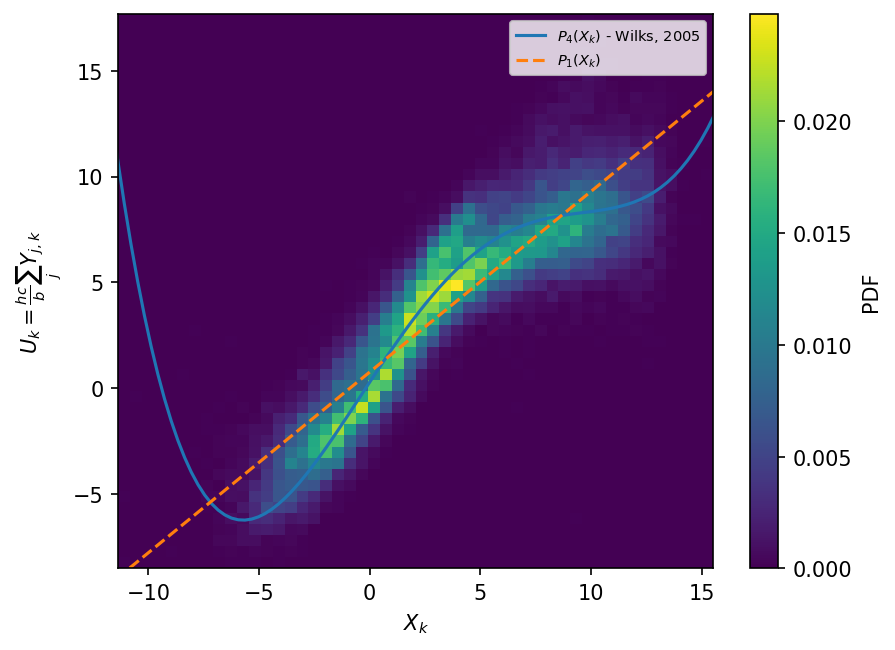

In [7]:
plt.figure(dpi=150)
# 2D histogram of X vs U
plt.hist2d(X_copy.flatten(), U_sample.flatten(), bins=50, density=True)
plt.xlabel("$X_k$")
plt.ylabel(r"$U_k = \frac{hc}{b}\sum_j Y_{j,k}$")
plt.colorbar(label="PDF")

# Fits from polynomials
x = np.linspace(-12, 18, 100)
plt.plot(x, np.polyval(p4, x), label="$P_4(X_k)$ - Wilks, 2005")
plt.plot(x, np.polyval(p1, x), "--", label="$P_1(X_k)$")


plt.legend(fontsize=7);

The figure above shows that the the relationship between the slow variables ($X_k$) and the observed coupling term ($U_k$) is non-linear. The higher order polynomlial, since it is more flexible, does a better job at capturing the overall pattern, relative to the linear fit. 

## Testing the effect of parameterizations in the "GCM" model

Now that we have a couple of different candidate parameterizations that can roughly predict the relationship between the slow variables and sub-grid forcing, we test their impact in a GCM simulation where the parameterization is required. We compare four simulations:
- "Real world": corresponding to the "truth" model goverened by the full two time-scale Lorenz-96 system.
- GCM without parameterization: corresponding to the one time-scale Lorenz-96 system without any the coupling term. We use a forward-Euler scheme to integrate the model forward.
- GCM with our parameterization: corresponding to the one time-scale Lorenz-96 system with the linear polynomial approximation of the coupling terms as obtained above.
- GCM with {cite}`Wilks2005` parameterization: corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.

In [8]:
# First we define the GCM
def GCM(X0, F, dt, nt, param=[0]):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X))
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time

In [9]:
np.random.seed(13)
T = 5
# Real world
X_true, Y_true, T_true = W.randomize_IC().run(0.05, T)
X_init, dt, F_mod = X_true[0] + 0.0 * np.random.randn(W.K), 0.002, W.F + 0.0
# The reason for adding the zero terms to X and F will become clear below, where the amplitude will be increased.

# no parameterization
X_gcm1, T_gcm1 = GCM(X_init, F_mod, dt, int(T / dt))
# Linear parameterization
X_gcm2, T_gcm2 = GCM(X_init, F_mod, dt, int(T / dt), param=p1)
# Wilks parameterization - 4th order polynomial.
X_gcm3, T_gcm3 = GCM(X_init, F_mod, dt, int(T / dt), param=p4)

Now we look at Hovmoeller plots of the different solutions.

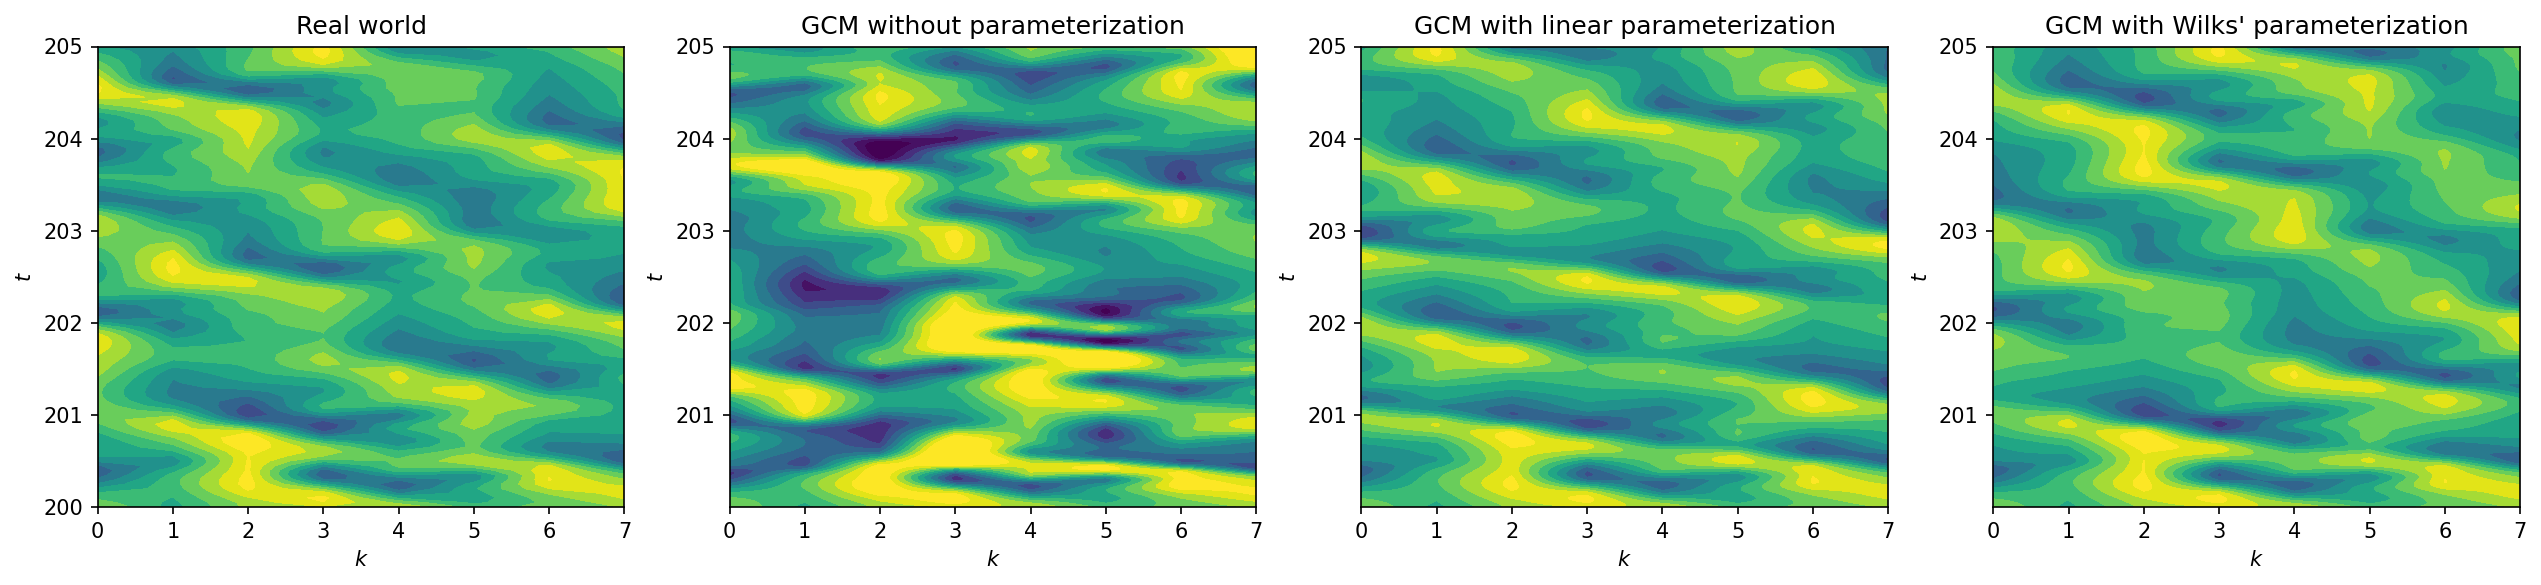

In [10]:
plt.figure(dpi=150, figsize=(17, 4))
lims = {"vmin": -12, "vmax": 12, "levels": np.linspace(-12, 12, 12), "extend": "both"}
plt.subplot(141)
plt.contourf(W.k, T_true + t[-1], X_true, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("Real world")
plt.subplot(142)
plt.contourf(W.k, T_gcm1 + t[-1], X_gcm1, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM without parameterization")
plt.subplot(143)
plt.contourf(W.k, T_gcm3 + t[-1], X_gcm2, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with linear parameterization")
plt.subplot(144)
plt.contourf(W.k, T_gcm2 + t[-1], X_gcm3, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with Wilks' parameterization")

plt.tight_layout()

The next plot shows the temporal evolution of the variable $X_3$ obtained with the four models listed above.

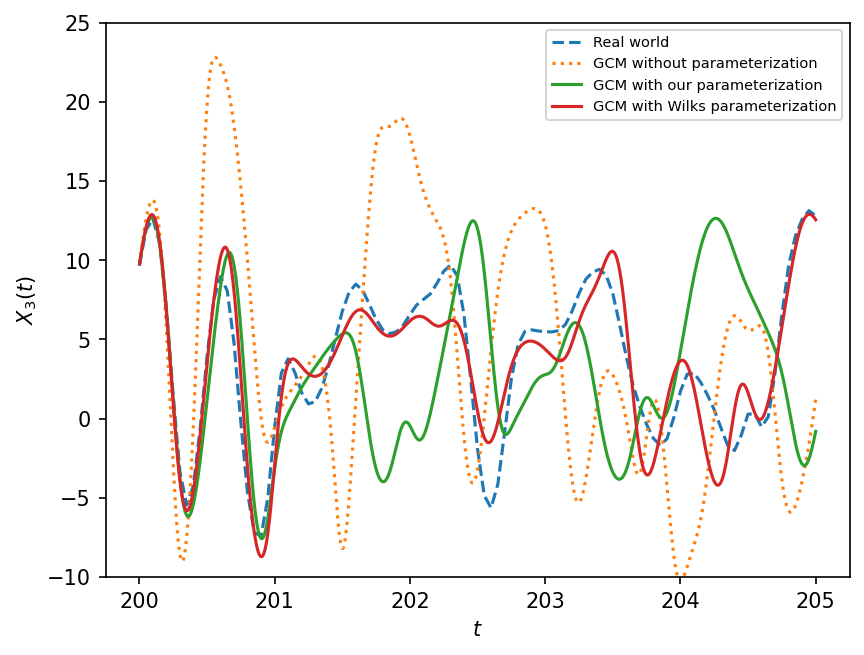

In [11]:
k = 3
plt.figure(dpi=150)
plt.plot(T_true + t[-1], X_true[:, k], "--", label="Real world")
plt.plot(T_gcm1 + t[-1], X_gcm1[:, k], ":", label="GCM without parameterization")
plt.plot(T_gcm1 + t[-1], X_gcm2[:, k], label="GCM with our parameterization")
plt.plot(T_gcm1 + t[-1], X_gcm3[:, k], label="GCM with Wilks parameterization")
plt.xlabel("$t$")
plt.ylabel("$X_3(t)$")
plt.legend(fontsize=7, loc=1)
plt.ylim(-10, 25);

As seen above, all the simulation diverge at long times,and the unparameterized simulation diverges very rapidly. On the other hand, the parameterized GCMs track the "real world" solution better. The Wilks parameterization does better than the linear fit.

## Sources of model error

We consider the following five sources of error:

1. Missing physics: which is modeled with a GCM without parameterization that corresponds to the one time-scale Lorenz-96 system without any the coupling term.
2. Poorly parameterized unresolved physics: which is studied by considering a first-order and third-order polynomial approximations of the coupling terms:
    \begin{equation*}
    P_4 \rightarrow P_1
    \end{equation*}
3. Unknown forcing: which is modeled by adding an error to the forcing term:
    \begin{equation*}
    F \rightarrow F + error
    \end{equation*}
4. Numerical approximation: which is studied by increasing the time-step:
    \begin{equation*}
    \Delta t \rightarrow 10 \Delta t
    \end{equation*}
5. Initialization error: which is modeled by adding an error to the initial condition:
    \begin{equation*}
    X(t=0) \rightarrow X(t=0) + error
    \end{equation*}
  
The next code estimates these sources of error and the next figure shows their relative contributions. For reference, we also plot the error of the GCM using {cite}`Wilks2005` polynomial coupling term and without any of the sources of error listed above. All errors are evaluated by comparing the GCMs to the "truth" model goverened by the full two time-scale Lorenz-96 system.

In [12]:
def err(X, X_true):
    return np.sqrt(((X - X_true[1:, :]) ** 2).mean(axis=1))

In [13]:
np.random.seed(13)
T, dt = 2, 0.001
X_tr, _, _ = W.randomize_IC().set_param(0.0001).run(dt, T)
X_gcm, T_c = GCM(W.X, W.F, dt, int(T / dt), param=p4)
X_frc, T_c = GCM(W.X, W.F + 1.0, dt, int(T / dt), param=p4)
X_ic, T_c = GCM(W.X + 0.5, W.F, dt, int(T / dt), param=p4)
X_dt, T_dt = GCM(W.X, W.F, 10 * dt, int(T / dt / 10), param=p4)
X_phys, _ = GCM(W.X, W.F, dt, int(T / dt))
X_prm, _ = GCM(W.X, W.F, dt, int(T / dt), param=p1)

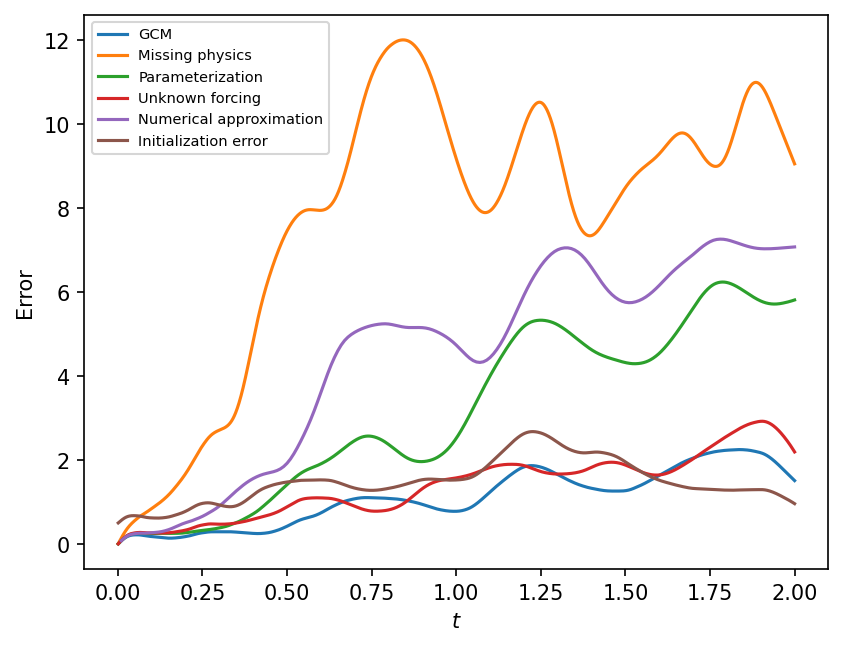

In [14]:
plt.figure(dpi=150)
plt.plot(T_c, err(X_gcm, X_tr), label="GCM")
plt.plot(T_c, err(X_phys, X_tr), label="Missing physics")
plt.plot(T_c, err(X_prm, X_tr), label="Parameterization")
plt.plot(T_c, err(X_frc, X_tr), label="Unknown forcing")
plt.plot(T_dt, err(X_dt, X_tr[::10]), label="Numerical approximation")
plt.plot(T_c, err(X_ic, X_tr), label="Initialization error")
plt.xlabel("$t$")
plt.ylabel("Error")
plt.legend(fontsize=7);

For this particular set of parameter values, the removal of the coupling term results in the highest error. The second and third sources of error correspond to the numerical error (introduced by increasing the time-step) and to the error resulting form poorly parameterized unresolved physics (modeled by consideing a first-order polynomial approximation of the coupling terms) respectively.

The errors introduced by an unknown forcing and a different initialization are the least among the sources of errors considered.

## Stochastic parameterizations

Next, we run the following two variations of two time-scale Lorenz-96:
1. The GCM with our parameterization corresponding to the one time-scale Lorenz-96 system, with the linear polynomial approximation of the coupling terms.
2. The GCM with {cite}`Wilks2005` parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.

In [15]:
# Build a 100-"day" climatology

T, dt = 100.0, 0.001
%time X_clim,Y_clim,T_clim = W.run(0.1, T)
%time X1,t1 = GCM(X_init, F_mod, dt, int(T/dt), param=p1)
%time X2,t2 = GCM(X_init, F_mod, dt, int(T/dt), param=p4)

CPU times: user 1min 6s, sys: 120 ms, total: 1min 7s
Wall time: 1min 7s
CPU times: user 2.04 s, sys: 53.2 ms, total: 2.09 s
Wall time: 2.06 s
CPU times: user 2.61 s, sys: 24.4 ms, total: 2.64 s
Wall time: 2.63 s


We compare the mean values of the slow variables $X_k$ , $k=1,\ldots,K$.

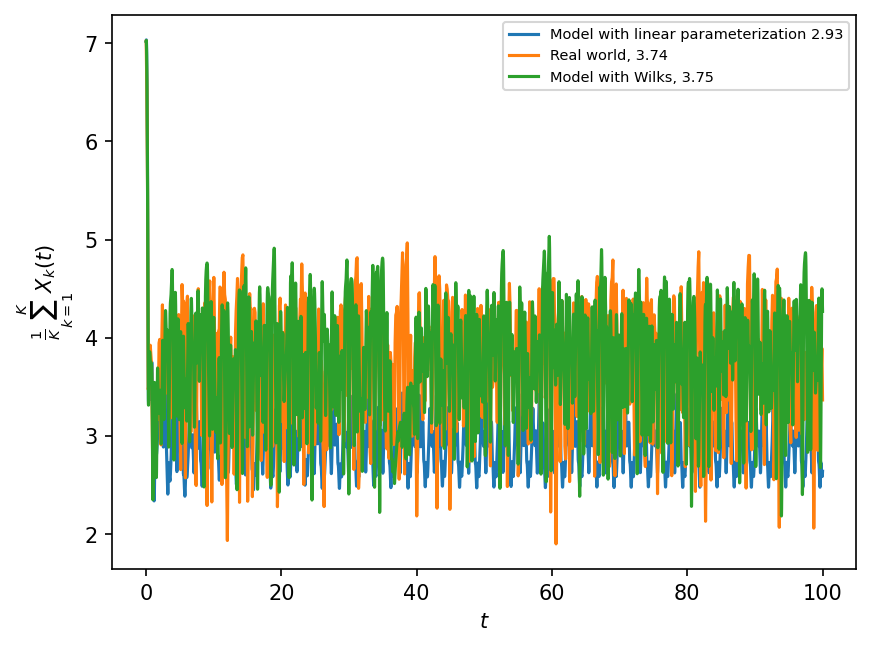

In [16]:
plt.figure(dpi=150)
plt.plot(
    t1, X1.mean(axis=1), label="Model with linear parameterization %.2f" % (X1.mean())
)
plt.plot(T_clim, X_clim.mean(axis=1), label="Real world, %.2f" % (X_true.mean()))
plt.plot(t2, X2.mean(axis=1), label="Model with Wilks, %.2f" % (X2.mean()))
plt.xlabel("$t$")
plt.ylabel(r"$\frac{1}{K}\sum_{k=1}^K X_k(t)$")
plt.legend(fontsize=7);

In [17]:
print("\n\n       Truth      P1   Wilks")
print("mean:  %.3f   %.3f   %.3f" % (X_true.mean(), X1.mean(), X2.mean()))
print("std:   %.3f   %.3f   %.3f" % (X_true.std(), X1.std(), X2.std()))



       Truth      P1   Wilks
mean:  3.741   2.926   3.750
std:   4.679   4.375   4.524


As expected, the {cite}`Wilks2005` parameterization gives a mean value of the slow variables that is closer to the one obtained with the "truth" model compared to the model with linear parameterization since {cite}`Wilks2005` coupling term is modeled with a third-order polynomial.

Next, we consider the model with the full parameterization proposed by {cite}`Wilks2005` by adding a stochastic component such that the parameterization has the following form: $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + b_4 X_k^4 + e_k$ where $e_k$ is a stochastic component.

In [18]:
def GCMs(X0, F, dt, nt, param=[0], stoch=1.0, phi=0.984):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()
    ek = np.zeros(X.size)

    for n in range(nt):
        # Red noise
        ek = phi * ek + stoch * np.sqrt((1 - phi) * (1 + phi)) * np.random.randn(X.size)
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X) + stoch * ek)
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time

In [19]:
np.random.seed(31)
%time X3,t3 = GCMs(X_init, F_mod, dt, int(T/dt), param=p4)

print("\n\n       Truth      P1      P4  P4+stoch")
print(
    "mean:  %.3f   %.3f   %.3f   %.3f"
    % (X_true.mean(), X1.mean(), X2.mean(), X3.mean())
)
print("std:   %.3f   %.3f   %.3f   %.3f" % (X_true.std(), X1.std(), X2.std(), X3.std()))

CPU times: user 4.41 s, sys: 13.7 ms, total: 4.42 s
Wall time: 4.53 s


       Truth      P1      P4  P4+stoch
mean:  3.741   2.926   3.750   3.758
std:   4.679   4.375   4.524   4.537


By comparing the mean and standard deviation values of the slow variables $X_k$ , $k=1,\ldots,K$, we do not see a significant improvement when adding the stochastic component $e_k$ to the third-order polynomial parameterization.

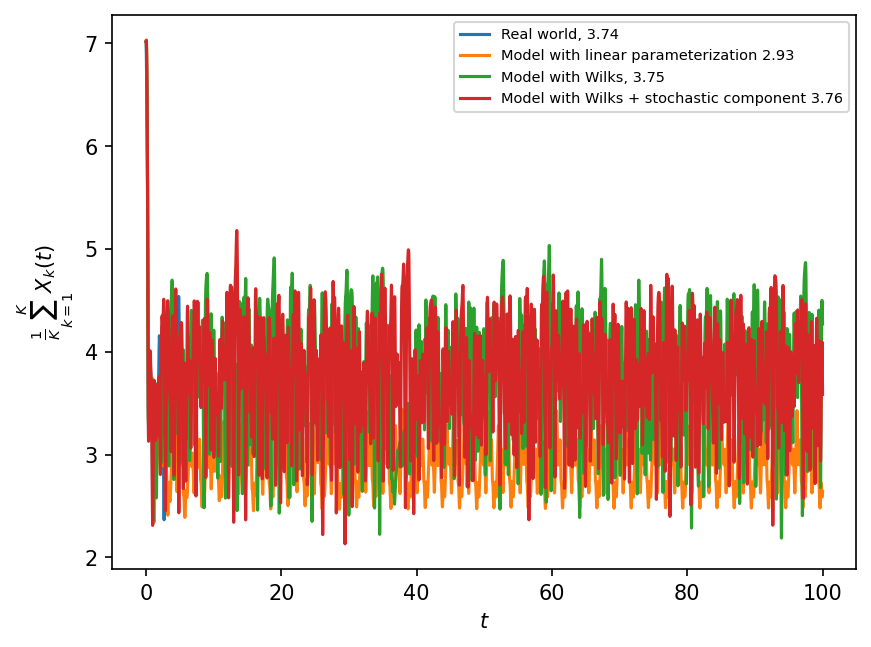

In [20]:
plt.figure(dpi=150)
plt.plot(T_true, X_true.mean(axis=1), label="Real world, %.2f" % (X_true.mean()))
plt.plot(
    t1, X1.mean(axis=1), label="Model with linear parameterization %.2f" % (X1.mean())
)
plt.plot(t2, X2.mean(axis=1), label="Model with Wilks, %.2f" % (X2.mean()))
plt.plot(
    t3,
    X3.mean(axis=1),
    label="Model with Wilks + stochastic component %.2f" % (X3.mean()),
)
plt.xlabel("$t$")
plt.ylabel(r"$\frac{1}{K}\sum_{k=1}^K X_k(t)$")
plt.legend(fontsize=7);

## Summary

In this chapter:
- We used the two time-scale Lorenz-96 model to generate a real world, or "truth", dataset
- We built a "GCM" with a rudimentary parameterization of coupling to unresolved processes ($\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}$)
- We deliberately used low-order integration and longer time-step for non-trivial numerical model errors.
- We compared the few different sources of errors in models.
- We also compared the results obtained:
  1. A GCM corresponding to the one time-scale Lorenz-96 system with a linear polynomial parameterization of the coupling terms.
  2. A GCM with {cite}`Wilks2005` parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.
  3. A GCM with the full {cite}`Wilks2005` parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms and a stochastic component.